In [1]:
# coding=utf-8
import os

from sklearn.metrics import f1_score
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from argparse import ArgumentParser
from dual_gnn.cached_gcn_conv import CachedGCNConv
from dual_gnn.dataset.DomainData import DomainData
from dual_gnn.ppmi_conv import PPMIConv
import random
import numpy as np
import torch
import torch.functional as F
from torch import nn
import torch.nn.functional as F
import itertools
import time
import warnings
import pickle 

warnings.filterwarnings("ignore", category=UserWarning)

#         lr     wd     pe   drop_out
# a-c   0.005   0.01   0.4     0.1
# a-d   0.005   0.01   0.4     0.1

# c-a   0.005   0.01   0.4
# c-d   0.005   0.01   0.4

# d-a   0.001   0.01   0.4
# d-c   0.001   0.01   0.4



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser = ArgumentParser()
parser.add_argument("--source", type=str, default='citationv1')
parser.add_argument("--target", type=str, default='dblpv7')
parser.add_argument("--name", type=str, default='UDAGCN')
parser.add_argument("--seed", type=int, default=1)
parser.add_argument("--UDAGCN", type=bool, default=False)
parser.add_argument("--learning_rate", type=float, default=5e-3)
parser.add_argument("--weight_decay", type=float, default=1e-2)
parser.add_argument("--drop_out", type=float, default=1e-1)

parser.add_argument("--perturb", type=bool, default=True)
parser.add_argument("--perturb_rate", type=float, default=0.1)
parser.add_argument("--encoder_dim", type=int, default=512)
parser.add_argument("--label_rate", type=float, default=0.05)

args = parser.parse_args(args=[])
seed = args.seed
use_UDAGCN = args.UDAGCN
encoder_dim = args.encoder_dim
use_perturb = args.perturb
perturb_rate = args.perturb_rate
label_rate = args.label_rate

id = "source: {}, target: {}, seed: {}, label_rate:{}, learning_rate: {}, weight_decay:{}, perturb_rate:{}, encoder_dim: {}" \
    .format(args.source, args.target, seed, label_rate, args.learning_rate, args.weight_decay, perturb_rate,
            encoder_dim)

print(id)

rate = 0.0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
dataset = DomainData("data/{}".format(args.source), name=args.source)
source_data = dataset[0]
print(source_data)
dataset = DomainData("data/{}".format(args.target), name=args.target)
target_data = dataset[0]
print(target_data)

source_data = source_data.to(device)
target_data = target_data.to(device)

source_train_size = int(source_data.size(0) * label_rate)
label_mask = np.array([1] * source_train_size + [0] * (source_data.size(0) - source_train_size)).astype(bool)
np.random.shuffle(label_mask)
label_mask = torch.tensor(label_mask).to(device)


class add_perturb(nn.Module):
    def __init__(self, dim1, dim2, beta):
        super(add_perturb, self).__init__()
        self.perturb = nn.Parameter(torch.FloatTensor(dim1, dim2).uniform_(-beta, beta).to(device))
        self.perturb.requires_grad_(True)

    def forward(self, input):
        return input + self.perturb


class GNN(torch.nn.Module):
    def __init__(self, base_model=None, type="gcn", **kwargs):
        super(GNN, self).__init__()

        if base_model is None:
            weights = [None, None]
            biases = [None, None]
        else:
            weights = [conv_layer.weight for conv_layer in base_model.conv_layers]
            biases = [conv_layer.bias for conv_layer in base_model.conv_layers]

        self.dropout_layers = [nn.Dropout(args.drop_out) for _ in weights]
        self.type = type

        model_cls = PPMIConv if type == "ppmi" else CachedGCNConv

        # self.trans = nn.Linear(dataset.num_features, encoder_dim)

        self.x_perturb = add_perturb(source_data.size(0), encoder_dim, perturb_rate)

        self.perturb_layers = nn.ModuleList([
            add_perturb(source_data.size(0), encoder_dim, perturb_rate),
            add_perturb(source_data.size(0), encoder_dim, perturb_rate)
        ])

        self.conv_layers = nn.ModuleList([
            model_cls(dataset.num_features, encoder_dim,
                      weight=weights[0],
                      bias=biases[0],
                      **kwargs),
            model_cls(encoder_dim, encoder_dim,
                      weight=weights[1],
                      bias=biases[1],
                      **kwargs)
        ])

    def forward(self, x, edge_index, cache_name, perturb):
        # if perturb:
        # x = self.x_perturb(x)
        for i, conv_layer in enumerate(self.conv_layers):
            x = conv_layer(x, edge_index, cache_name)
            if perturb:
                x = self.perturb_layers[i](x)
            if i < len(self.conv_layers) - 1:
                x = F.relu(x)
                x = self.dropout_layers[i](x)
        return x


class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg() * rate
        return grad_output, None


class GRL(nn.Module):
    def forward(self, input):
        return GradReverse.apply(input)


# addp = add_perturb(source_data.size(0), encoder_dim, 8e-3, device)

loss_func = nn.CrossEntropyLoss().to(device)

encoder = GNN(type="gcn").to(device)
if use_UDAGCN:
    ppmi_encoder = GNN(base_model=encoder, type="ppmi", path_len=10).to(device)

cls_model = nn.Sequential(
    nn.Linear(encoder_dim, dataset.num_classes),
).to(device)

cls_model1 = nn.Sequential(
    nn.Linear(encoder_dim, dataset.num_classes),
).to(device)

# source_data.x = addp(source_data.x)


domain_model = nn.Sequential(
    GRL(),
    nn.Linear(encoder_dim, 64),
    nn.ReLU(),
    nn.Dropout(args.drop_out),
    nn.Linear(64, 2),
).to(device)


class Attention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.dense_weight = nn.Linear(in_channels, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, inputs):
        stacked = torch.stack(inputs, dim=1)
        weights = F.softmax(self.dense_weight(stacked), dim=1)
        outputs = torch.sum(stacked * weights, dim=1)
        return outputs


att_model = Attention(encoder_dim).cuda()

models = [encoder, cls_model, domain_model, cls_model1]
if use_UDAGCN:
    models.extend([ppmi_encoder, att_model])
params = itertools.chain(*[model.parameters() for model in models])
optimizer = torch.optim.Adam(params, lr=args.learning_rate, weight_decay=args.weight_decay)


def gcn_encode(data, cache_name, perturb=False, mask=None):
    encoded_output = encoder(data.x, data.edge_index, cache_name, perturb)
    if mask is not None:
        encoded_output = encoded_output[mask]
    return encoded_output


def ppmi_encode(data, cache_name, perturb=False, mask=None):
    encoded_output = ppmi_encoder(data.x, data.edge_index, cache_name, perturb)
    if mask is not None:
        encoded_output = encoded_output[mask]
    return encoded_output


def encode(data, cache_name, perturb=False, mask=None):
    gcn_output = gcn_encode(data, cache_name, perturb, mask)
    if use_UDAGCN:
        ppmi_output = ppmi_encode(data, cache_name, perturb, mask)
        outputs = att_model([gcn_output, ppmi_output])
        return outputs
    else:
        return gcn_output


def predict(data, cache_name, perturb=False, mask=None):
    encoded_output = encode(data, cache_name, perturb, mask)
    logits = cls_model(encoded_output)
    return logits


def evaluate(preds, labels):
    corrects = preds.eq(labels)
    accuracy = corrects.float().mean()
    macro_f1 = f1_score(labels.cpu().detach(), preds.cpu().detach(), average='macro')
    micro_f1 = f1_score(labels.cpu().detach(), preds.cpu().detach(), average='micro')
    return accuracy, macro_f1, micro_f1


def test(data, cache_name, perturb=False, mask=None):
    for model in models:
        model.eval()
    #logits = predict(data, cache_name, perturb, mask)
    encoded_output = encode(data, cache_name, perturb, mask)
    logits = cls_model(encoded_output)
    preds = logits.argmax(dim=1)
    labels = data.y if mask is None else data.y[mask]
    accuracy, macro_f1, micro_f1 = evaluate(preds, labels)
    return accuracy, macro_f1, micro_f1, encoded_output


epochs = 200


def train(epoch):
    for model in models:
        model.train()
    optimizer.zero_grad()

    global rate
    rate = min((epoch + 1) / epochs, 0.05)

    encoded_source = encode(source_data, "source", use_perturb)
    encoded_source_o = encode(source_data, "source")
    encoded_target = encode(target_data, "target")
    source_logits = cls_model(encoded_source)
    source_logits_o = cls_model1(encoded_source_o)

    # use source classifier loss:
    cls_loss = loss_func(source_logits_o[label_mask], source_data.y[label_mask]) + loss_func(source_logits[label_mask],
                                                                                             source_data.y[label_mask])

    '''
    source_probs = F.softmax(source_logits, dim=-1)
    source_probsl = torch.clamp(source_probs, min=1e-9, max=1.0)
    source_probs_o = F.softmax(source_logits_o, dim=-1)
    source_probs_ol = torch.clamp(source_probs_o, min=1e-9, max=1.0)

    
    loss_cross_1 = torch.mean(torch.sum(-source_probs[~label_mask] * torch.log(source_probs_ol[~label_mask]), dim=-1))
    loss_cross_2 = torch.mean(torch.sum(-source_probs_o[~label_mask] * torch.log(source_probsl[~label_mask]), dim=-1))

    semi_loss = loss_cross_1 + loss_cross_2
    
    '''
    _, s_label_1 = torch.max(source_logits, dim=1)
    _, s_label_2 = torch.max(source_logits_o, dim=1)

    semi_loss = loss_func(source_logits[~label_mask], s_label_2[~label_mask]) + loss_func(source_logits_o[~label_mask],
                                                                                          s_label_1[~label_mask])

    # for model in models:
    #    for name, param in model.named_parameters():
    #        if "weight" in name:
    #            cls_loss = cls_loss + param.mean() * 3e-3

    # if use_UDAGCN:
    # use domain classifier loss:
    # encoded_source = addp(encoded_source)
    source_domain_preds = domain_model(encoded_source)
    target_domain_preds = domain_model(encoded_target)

    source_domain_cls_loss = loss_func(
        source_domain_preds,
        torch.zeros(source_domain_preds.size(0)).type(torch.LongTensor).to(device)
    )
    target_domain_cls_loss = loss_func(
        target_domain_preds,
        torch.ones(target_domain_preds.size(0)).type(torch.LongTensor).to(device)
    )
    loss_grl = source_domain_cls_loss + target_domain_cls_loss
    # print (cls_loss.cpu().detach().numpy(), loss_grl.cpu().detach().numpy(), semi_loss.cpu().detach().numpy())
    loss = cls_loss + loss_grl + (float(epoch) / epochs) * semi_loss
    # print (cls_loss, loss_grl, semi_loss)

    # use target classifier loss:
    # target_logits = cls_model(encoded_target)
    # target_probs = F.softmax(target_logits, dim=-1)
    # target_probs = torch.clamp(target_probs, min=1e-9, max=1.0)

    # loss_entropy = torch.mean(torch.sum(-target_probs * torch.log(target_probs), dim=-1))

    # loss = loss + loss_entropy* (epoch / epochs * 0.01)

    # else:
    #    loss = cls_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


best_source_acc = 0.0
best_target_acc = 0.0
best_epoch = 0.0
best_macro_f1 = 0.0
for epoch in range(1, epochs):
    train(epoch)
    # print(addp.perturb)
    _, _, _, output_source = test(source_data, "source")
    source_correct, _, _, output_source_p = test(source_data, "source", use_perturb)
    target_correct, macro_f1, micro_f1, output_target = test(target_data, "target")
    print("Epoch: {}, source_acc: {}, target_acc: {}, macro_f1: {}, micro_f1: {}".format(epoch, source_correct,
                                                                                         target_correct, macro_f1,
                                                                                         micro_f1))
    if macro_f1 > best_macro_f1:
        best_target_acc = target_correct
        best_source_acc = source_correct
        best_macro_f1 = macro_f1
        best_micro_f1 = micro_f1
        best_epoch = epoch
        with open ('log/{}_{}_embeddings.pkl'.format(args.source, args.target),'wb') as f:
            pickle.dump([output_source.cpu().detach().numpy(), 
                         output_source_p.cpu().detach().numpy(), output_target.cpu().detach().numpy()], f)
print("=============================================================")
line = "{}\n - Epoch: {}, best_source_acc: {}, best_target_acc: {}, best_macro_f1: {}, best_micro_f1: {}" \
    .format(id, best_epoch, best_source_acc, best_target_acc, best_macro_f1, best_micro_f1)

print(line)

'''
with open("log/{}-{}.txt".format(args.source, args.target), 'a') as f:
    line = "{} - Epoch: {}, best_source_acc: {}, best_target_acc: {}, best_macro_f1: {}, best_micro_f1: {}" \
               .format(id, best_epoch, best_source_acc, best_target_acc, best_macro_f1, best_micro_f1) + time.strftime(
        '%Y-%m-%d %H:%M:%S', time.localtime(time.time())) + "\n"
    f.write(line)
'''

source: citationv1, target: dblpv7, seed: 1, label_rate:0.05, learning_rate: 0.005, weight_decay:0.01, perturb_rate:0.1, encoder_dim: 512
Data(x=[8935, 6775], edge_index=[2, 30211], y=[8935], train_mask=[8935], val_mask=[8935], test_mask=[8935])
Data(x=[5484, 6775], edge_index=[2, 16247], y=[5484], train_mask=[5484], val_mask=[5484], test_mask=[5484])
Epoch: 1, source_acc: 0.2665920555591583, target_acc: 0.21699489653110504, macro_f1: 0.0717699749560666, micro_f1: 0.21699489423778265
Epoch: 2, source_acc: 0.2558477818965912, target_acc: 0.21663020551204681, macro_f1: 0.07122302158273382, micro_f1: 0.21663019693654267
Epoch: 3, source_acc: 0.2567431628704071, target_acc: 0.21699489653110504, macro_f1: 0.07168636676137068, micro_f1: 0.21699489423778265
Epoch: 4, source_acc: 0.4719642102718353, target_acc: 0.42195478081703186, macro_f1: 0.2849168566551307, micro_f1: 0.4219547775346462
Epoch: 5, source_acc: 0.6616675853729248, target_acc: 0.5807804465293884, macro_f1: 0.4680485071017233, m

Epoch: 61, source_acc: 0.7552322745323181, target_acc: 0.6763311624526978, macro_f1: 0.5604481661326844, micro_f1: 0.6763311451495259
Epoch: 62, source_acc: 0.7560156583786011, target_acc: 0.6787016987800598, macro_f1: 0.5616753581989571, micro_f1: 0.6787016776075857
Epoch: 63, source_acc: 0.7557918429374695, target_acc: 0.6819839477539062, macro_f1: 0.564473255587098, micro_f1: 0.6819839533187454
Epoch: 64, source_acc: 0.7555680274963379, target_acc: 0.6783369779586792, macro_f1: 0.558785016387939, micro_f1: 0.6783369803063457
Epoch: 65, source_acc: 0.7556799054145813, target_acc: 0.6772428750991821, macro_f1: 0.557989693515099, micro_f1: 0.6772428884026258
Epoch: 66, source_acc: 0.7557918429374695, target_acc: 0.6754193902015686, macro_f1: 0.5573493140987622, micro_f1: 0.675419401896426
Epoch: 67, source_acc: 0.7557918429374695, target_acc: 0.6757841110229492, macro_f1: 0.5566946960828153, micro_f1: 0.6757840991976659
Epoch: 68, source_acc: 0.7557918429374695, target_acc: 0.678154647

Epoch: 124, source_acc: 0.7556799054145813, target_acc: 0.6792487502098083, macro_f1: 0.5606827068773699, micro_f1: 0.6792487235594457
Epoch: 125, source_acc: 0.7556799054145813, target_acc: 0.6765134930610657, macro_f1: 0.5569393677899466, micro_f1: 0.6765134938001459
Epoch: 126, source_acc: 0.7556799054145813, target_acc: 0.6735959053039551, macro_f1: 0.55606289492801, micro_f1: 0.6735959153902261
Epoch: 127, source_acc: 0.7556799054145813, target_acc: 0.668854832649231, macro_f1: 0.5513815183650584, micro_f1: 0.6688548504741065
Epoch: 128, source_acc: 0.7556799054145813, target_acc: 0.6708607077598572, macro_f1: 0.5530654274842688, micro_f1: 0.6708606856309264
Epoch: 129, source_acc: 0.7556799054145813, target_acc: 0.6721371412277222, macro_f1: 0.554462517742313, micro_f1: 0.6721371261852662
Epoch: 130, source_acc: 0.7556799054145813, target_acc: 0.668672502040863, macro_f1: 0.5524629308271344, micro_f1: 0.6686725018234865
Epoch: 131, source_acc: 0.7556799054145813, target_acc: 0.67

Epoch: 186, source_acc: 0.7516508102416992, target_acc: 0.6471553444862366, macro_f1: 0.5369378956841093, micro_f1: 0.6471553610503282
Epoch: 187, source_acc: 0.7553441524505615, target_acc: 0.6880014538764954, macro_f1: 0.5679272100197108, micro_f1: 0.6880014587892049
Epoch: 188, source_acc: 0.7552322745323181, target_acc: 0.6943836808204651, macro_f1: 0.572749069430355, micro_f1: 0.6943836615609045
Epoch: 189, source_acc: 0.7527700066566467, target_acc: 0.663749098777771, macro_f1: 0.5503928332353819, micro_f1: 0.6637490882567469
Epoch: 190, source_acc: 0.7529938817024231, target_acc: 0.6580963134765625, macro_f1: 0.5455176482168508, micro_f1: 0.6580962800875274
Epoch: 191, source_acc: 0.7554560899734497, target_acc: 0.6960248351097107, macro_f1: 0.575465161977941, micro_f1: 0.6960247994164843
Epoch: 192, source_acc: 0.7536653876304626, target_acc: 0.6739606261253357, macro_f1: 0.5563634643307852, micro_f1: 0.6739606126914661
Epoch: 193, source_acc: 0.7529938817024231, target_acc: 0.

'\nwith open("log/{}-{}.txt".format(args.source, args.target), \'a\') as f:\n    line = "{} - Epoch: {}, best_source_acc: {}, best_target_acc: {}, best_macro_f1: {}, best_micro_f1: {}"                .format(id, best_epoch, best_source_acc, best_target_acc, best_macro_f1, best_micro_f1) + time.strftime(\n        \'%Y-%m-%d %H:%M:%S\', time.localtime(time.time())) + "\n"\n    f.write(line)\n'

/home/xiaomeng/miniconda3/envs/finatech/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/xiaomeng/miniconda3/envs/finatech/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


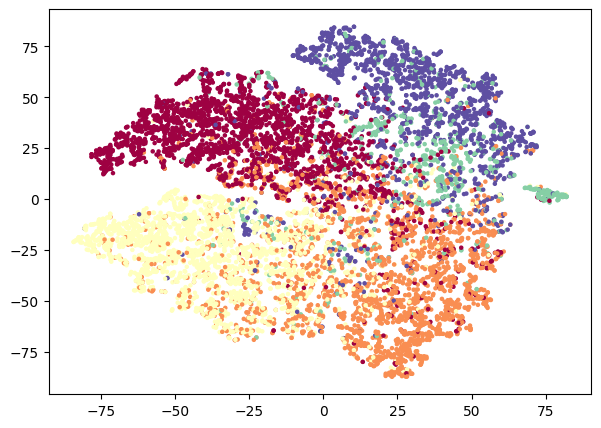

In [2]:
import pickle 
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt

with open ('log/{}_{}_embeddings.pkl'.format(args.source, args.target),'rb') as f:
    [output_source, output_source_p, output_target] = pickle.load(f)

sy = source_data.y.cpu().detach().numpy()
ty = target_data.y.cpu().detach().numpy()

tsne = TSNE(n_components=2)
X = np.append(np.append(output_source, output_source_p, 0), output_target, 0)

X_tsne = tsne.fit_transform(X)

sX_tsne = X_tsne[:len(sy)]
spX_tsne = X_tsne[len(sy):len(sy)*2]
tX_tsne = X_tsne[len(sy)*2:]

fig = plt.figure(figsize=(7, 5))
plt.scatter(spX_tsne[:, 0], spX_tsne[:, 1], s=5, c=sy, cmap=plt.cm.Spectral)
#plt.scatter(tX_tsne[:, 0], tX_tsne[:, 1], s=5, c=ty, marker ='s', cmap=plt.cm.Spectral)

#plt.savefig('img/cora.pdf',dpi=600, bbox_inches='tight')
plt.show()

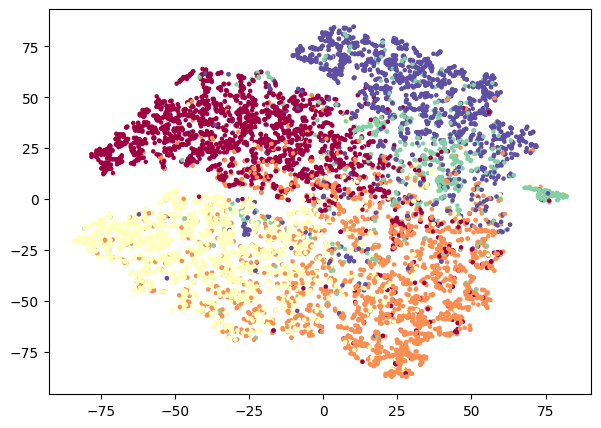

In [3]:
fig = plt.figure(figsize=(7, 5))
#plt.scatter(sX_tsne[:, 0], sX_tsne[:, 1], s=1, c=sy, marker ='o',cmap=plt.cm.Spectral)
plt.scatter(sX_tsne[:, 0], sX_tsne[:, 1], s=5, c=sy, marker ='o',cmap=plt.cm.Spectral)
#plt.scatter(tX_tsne[:, 0], tX_tsne[:, 1], s=1, c=ty, marker ='s', cmap=plt.cm.Spectral)

#plt.savefig('img/cora.pdf',dpi=600, bbox_inches='tight')
plt.show()

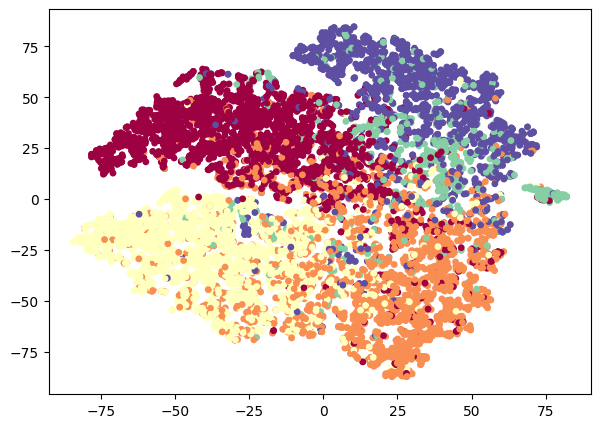

In [4]:
fig = plt.figure(figsize=(7, 5))
#plt.scatter(sX_tsne[:, 0], sX_tsne[:, 1], s=1, c=sy, marker ='o',cmap=plt.cm.Spectral)
plt.scatter(spX_tsne[:, 0], spX_tsne[:, 1], s=15, c=sy, marker ='o',cmap=plt.cm.Spectral)
#plt.scatter(tX_tsne[:, 0], tX_tsne[:, 1], s=1, c=ty, marker ='s', cmap=plt.cm.Spectral)

plt.savefig('img/TACO_sp.pdf',dpi=600, bbox_inches='tight')
plt.show()

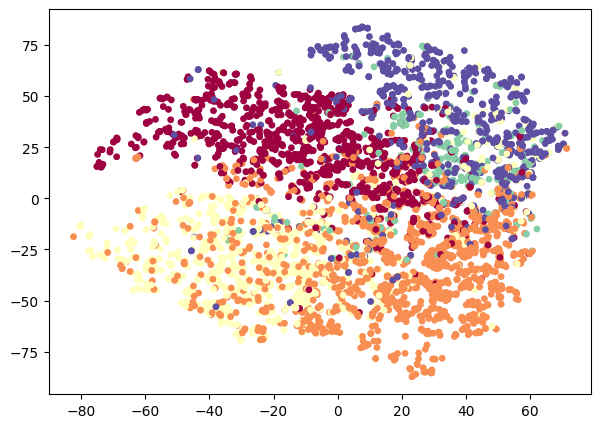

In [5]:
#sX_tsne = X_tsne[:len(sy)]
#tX_tsne = X_tsne[len(sy):]

fig = plt.figure(figsize=(7, 5))
#plt.scatter(sX_tsne[:, 0], sX_tsne[:, 1], s=1, c=sy, marker ='o',cmap=plt.cm.Spectral)
plt.scatter(tX_tsne[:, 0], tX_tsne[:, 1], s=15, c=ty, marker ='o', cmap=plt.cm.Spectral)

plt.savefig('img/TACO_t.pdf',dpi=600, bbox_inches='tight')
plt.show()

In [6]:

np.savetxt("csv/CD_TACO_spX.csv", spX_tsne, delimiter=',')
np.savetxt("csv/CD_TACO_tx.csv", tX_tsne, delimiter=',')
#np.savetxt("csv/Ay.csv", sy.astype(int), delimiter=',')
np.savetxt("csv/Dy.csv", ty.astype(int), delimiter=',')

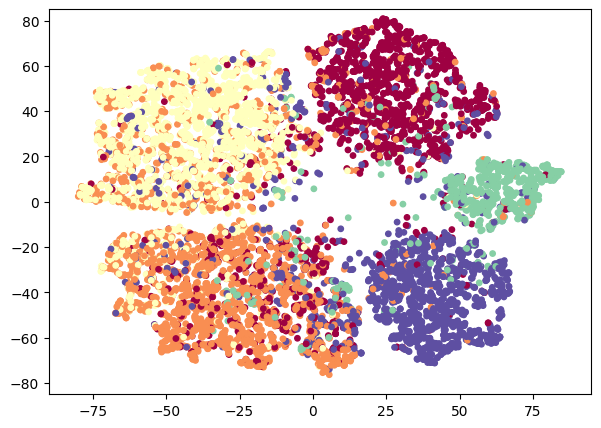

In [82]:
import numpy as np
import pickle 
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt


spX_tsne = np.loadtxt("csv/AC_TACO_spX.csv", delimiter=',')
sy = np.loadtxt("csv/Ay.csv", delimiter=',').astype(int)

fig = plt.figure(figsize=(7, 5))
plt.ylim((-85, 85))
plt.xlim((-90, 95))
plt.scatter(spX_tsne[:, 0], spX_tsne[:, 1], s=15, c=sy, marker ='o', cmap=plt.cm.Spectral)

plt.savefig('img/AC_TACO_spX.png',dpi=100, bbox_inches='tight')
plt.show()

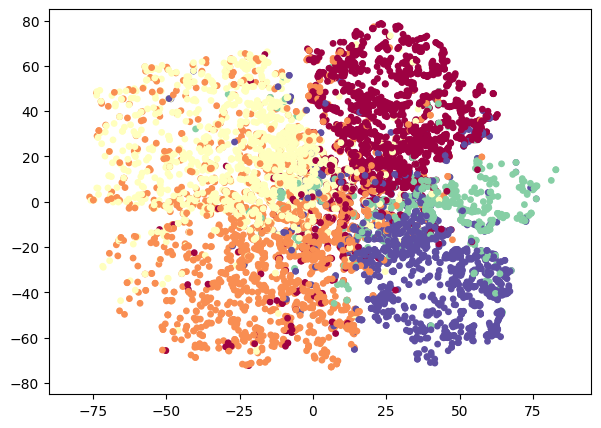

In [83]:
import numpy as np
import pickle 
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt


spX_tsne = np.loadtxt("csv/AC_TACO_tx.csv", delimiter=',')
sy = np.loadtxt("csv/Cy.csv", delimiter=',').astype(int)

fig = plt.figure(figsize=(7, 5))
plt.ylim((-85, 85))
plt.xlim((-90, 95))
plt.scatter(spX_tsne[:, 0], spX_tsne[:, 1], s=15, c=sy, marker ='o', cmap=plt.cm.Spectral)

plt.savefig('img/AC_TACO_tX.png',dpi=100, bbox_inches='tight')
plt.show()

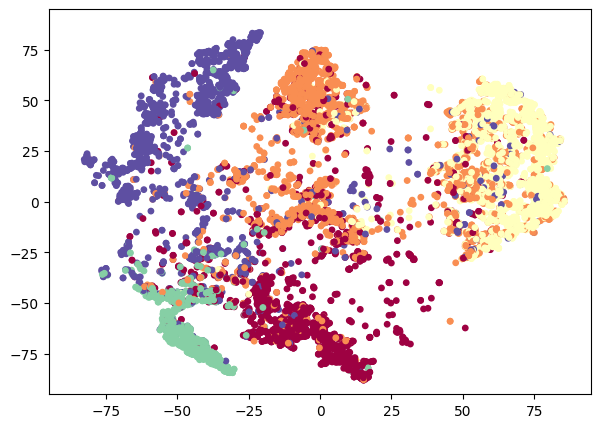

In [84]:
import numpy as np
import pickle 
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt


spX_tsne = np.loadtxt("csv/AC_UG_sX.csv", delimiter=',')
sy = np.loadtxt("csv/Ay.csv", delimiter=',').astype(int)

fig = plt.figure(figsize=(7, 5))
plt.xlim((-95, 95))
plt.ylim((-95, 95))
plt.scatter(spX_tsne[:, 0], spX_tsne[:, 1], s=15, c=sy, marker ='o', cmap=plt.cm.Spectral)

plt.savefig('img/AC_UG_sX.png',dpi=100, bbox_inches='tight')
plt.show()

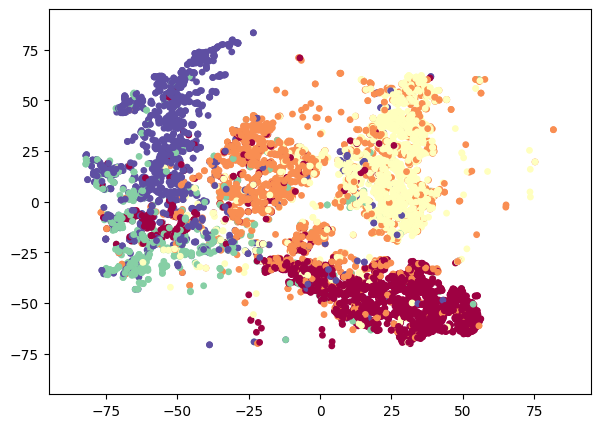

In [85]:
import numpy as np
import pickle 
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt


spX_tsne = np.loadtxt("csv/AC_UG_tx.csv", delimiter=',')
sy = np.loadtxt("csv/Cy.csv", delimiter=',').astype(int)

fig = plt.figure(figsize=(7, 5))
plt.ylim((-95, 95))
plt.xlim((-95, 95))
plt.scatter(spX_tsne[:, 0], spX_tsne[:, 1], s=15, c=sy, marker ='o', cmap=plt.cm.Spectral)

plt.savefig('img/AC_UG_tX.png',dpi=100, bbox_inches='tight')
plt.show()

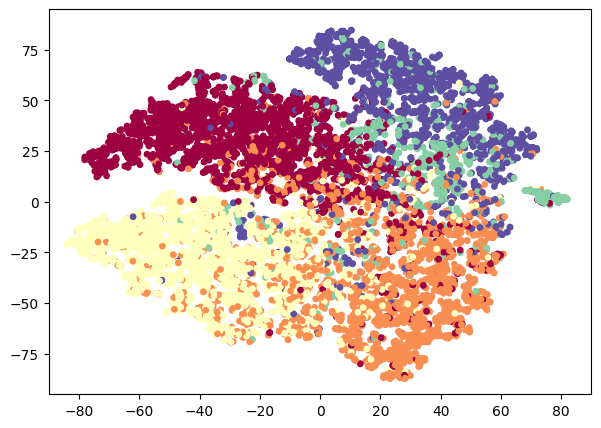

In [86]:
import numpy as np
import pickle 
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt


spX_tsne = np.loadtxt("csv/CD_TACO_spX.csv", delimiter=',')
sy = np.loadtxt("csv/Cy.csv", delimiter=',').astype(int)

fig = plt.figure(figsize=(7, 5))
plt.xlim((-90, 90))
plt.ylim((-95, 95))
plt.scatter(spX_tsne[:, 0], spX_tsne[:, 1], s=15, c=sy, marker ='o', cmap=plt.cm.Spectral)

plt.savefig('img/CD_TACO_sX.png',dpi=100, bbox_inches='tight')
plt.show()

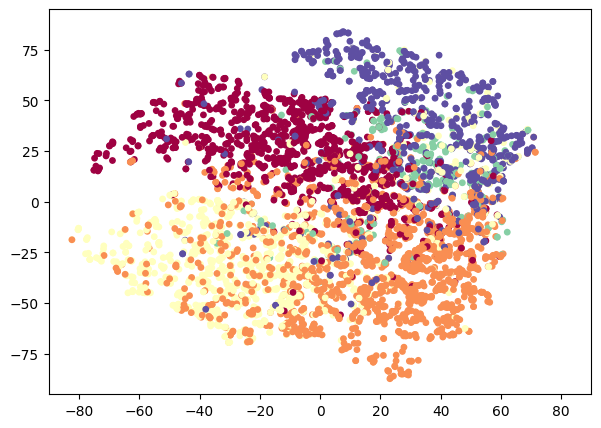

In [87]:
import numpy as np
import pickle 
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt


spX_tsne = np.loadtxt("csv/CD_TACO_tx.csv", delimiter=',')
sy = np.loadtxt("csv/Dy.csv", delimiter=',').astype(int)

fig = plt.figure(figsize=(7, 5))

plt.xlim((-90, 90))
plt.ylim((-95, 95))
plt.scatter(spX_tsne[:, 0], spX_tsne[:, 1], s=15, c=sy, marker ='o', cmap=plt.cm.Spectral)

plt.savefig('img/CD_TACO_tX.png',dpi=100, bbox_inches='tight')
plt.show()

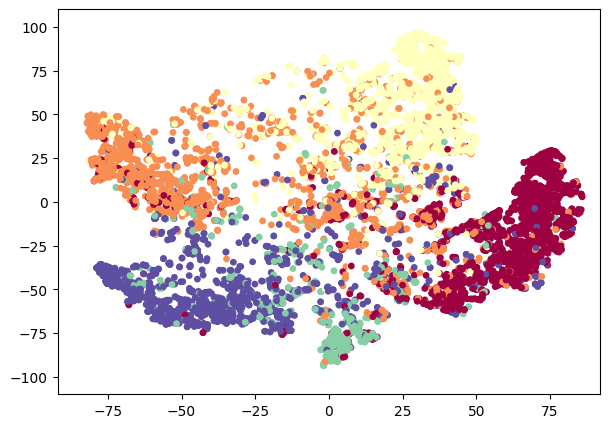

In [88]:
import numpy as np
import pickle 
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt


spX_tsne = np.loadtxt("csv/CD_UG_sX.csv", delimiter=',')
sy = np.loadtxt("csv/Cy.csv", delimiter=',').astype(int)

fig = plt.figure(figsize=(7, 5))
plt.xlim((-92, 92))
plt.ylim((-110, 110))
plt.scatter(spX_tsne[:, 0], spX_tsne[:, 1], s=15, c=sy, marker ='o', cmap=plt.cm.Spectral)

plt.savefig('img/CD_UG_sX.png',dpi=100, bbox_inches='tight')
plt.show()

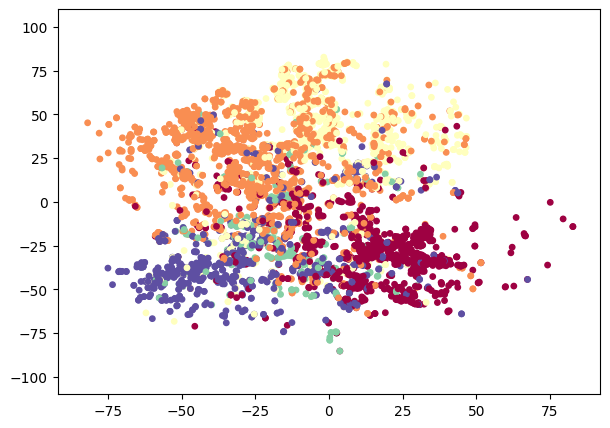

In [89]:
import numpy as np
import pickle 
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt


spX_tsne = np.loadtxt("csv/CD_UG_tx.csv", delimiter=',')
sy = np.loadtxt("csv/Dy.csv", delimiter=',').astype(int)

fig = plt.figure(figsize=(7, 5))

plt.xlim((-92, 92))
plt.ylim((-110, 110))
plt.scatter(spX_tsne[:, 0], spX_tsne[:, 1], s=15, c=sy, marker ='o', cmap=plt.cm.Spectral)

plt.savefig('img/CD_UG_tX.png',dpi=100, bbox_inches='tight')
plt.show()

In [2]:
import torch 
beta = 1e-3
a = torch.FloatTensor(3, 3).uniform_(-beta, beta)

print (a)

tensor([[ 0.0004, -0.0004, -0.0007],
        [-0.0005,  0.0010, -0.0007],
        [ 0.0008,  0.0002,  0.0006]])


In [4]:
import torch 
beta = 1e-6
a = torch.FloatTensor(4, 4).uniform_(-beta, beta)
b = torch.norm(a, p ='fro')
c = 2*a/b
d = torch.norm(c, p ='fro')
print (a)
print (b)
print (c)
print (d)

tensor([[-2.2762e-07,  9.7390e-08, -1.0380e-07, -1.0996e-07],
        [-7.6712e-07,  5.7357e-07, -8.1786e-07,  7.5368e-07],
        [-3.9850e-07,  1.7799e-08,  5.6698e-07,  2.1975e-07],
        [ 3.2451e-07, -8.5812e-07, -5.0525e-07,  2.0893e-08]])
tensor(1.9659e-06)
tensor([[-0.2316,  0.0991, -0.1056, -0.1119],
        [-0.7804,  0.5835, -0.8320,  0.7667],
        [-0.4054,  0.0181,  0.5768,  0.2236],
        [ 0.3301, -0.8730, -0.5140,  0.0213]])
tensor(2.)


In [2]:
b = torch.norm(a, p ='fro')
c = 1*a/b
d = torch.norm(c, p ='fro')
print (a)
print (b)
print (c)
print (d)

tensor([[ 1.8599e-07, -4.7281e-07, -2.9129e-07,  ..., -5.0822e-07,
          6.5017e-07,  5.7339e-07],
        [-7.7810e-07,  7.4442e-07, -9.4727e-07,  ...,  2.2980e-07,
          6.2136e-07, -6.8026e-07],
        [-6.1680e-07,  1.4862e-07, -5.6827e-07,  ...,  2.4329e-07,
         -6.8409e-07,  7.5515e-07],
        ...,
        [ 1.1871e-07, -7.9476e-07, -8.8533e-07,  ..., -5.7328e-07,
          5.0472e-08, -3.4134e-07],
        [ 9.3686e-07, -6.2939e-07, -2.1712e-07,  ..., -4.3754e-07,
          6.9716e-07,  4.6130e-07],
        [ 8.3394e-08,  9.6200e-07,  2.5761e-07,  ..., -4.5517e-07,
          5.1886e-07,  4.2035e-07]])
tensor(5.7882e-05)
tensor([[ 0.0032, -0.0082, -0.0050,  ..., -0.0088,  0.0112,  0.0099],
        [-0.0134,  0.0129, -0.0164,  ...,  0.0040,  0.0107, -0.0118],
        [-0.0107,  0.0026, -0.0098,  ...,  0.0042, -0.0118,  0.0130],
        ...,
        [ 0.0021, -0.0137, -0.0153,  ..., -0.0099,  0.0009, -0.0059],
        [ 0.0162, -0.0109, -0.0038,  ..., -0.0076,  0.01